# 3D MMI Workflow: From FDTD to Circuit-Ready S-Parameters

This notebook builds and characterizes a **3D multimode interference (MMI) coupler** in BEAMZ.  
It produces:
- a single-frequency **3x3 S-matrix** at the design wavelength,
- broadband transfer curves from FFT (
  $S_{11}(\lambda)$, $S_{21}(\lambda)$, $S_{31}(\lambda)$
),
- and an exportable dataset suitable for circuit-level modeling.

**Author:** Quentin Wach  
**Published:** 2026-02-15  
**Updated:** 2026-02-15  
**Tags:** Simulation, 3D, MMI, Characterization, S-Parameters  
**Beamz Version:** 0.1.20

## 1) Dependency Guard and Imports

In [1]:
import importlib.util

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from beamz import *
from beamz.devices.sources.signals import plot_signal

# ModeSource currently requires tidy3d for eigenmode solving.
if importlib.util.find_spec("tidy3d") is None:
    raise ImportError(
        "This notebook requires tidy3d for ModeSource initialization. "
        "Install it with: pip install tidy3d"
    )

## 2) Global Parameters (Balanced Runtime Profile)

In [2]:
# Units and constants
WL0 = 1.55 * um
F0 = LIGHT_SPEED / WL0

# Materials (Si / SiO2 example)
N_CORE = 3.45
N_CLAD = 1.444
EPS_CORE = N_CORE**2
EPS_CLAD = N_CLAD**2

# Geometry (balanced-size 3D demo)
WG_W = 0.50 * um
WG_H = 0.22 * um
MMI_W = 2.20 * um
MMI_L = 7.00 * um

LEAD_IN = 2.50 * um
LEAD_OUT = 2.50 * um
PORT_OFFSET = 0.65 * um

X = LEAD_IN + MMI_L + LEAD_OUT
Y = max(4.0 * um, MMI_W + 1.2 * um)
Z = 1.8 * um

# Resolution and time step
DX, DT = calc_optimal_fdtd_params(
    wavelength=WL0,
    n_max=N_CORE,
    dims=3,
    points_per_wavelength=9,
)

# Port locations
x_src = 0.90 * um
x_in_mon = 1.60 * um
x_out_mon = X - 1.60 * um

y_mid = Y / 2
y_top = y_mid + PORT_OFFSET
y_bot = y_mid - PORT_OFFSET
z_mid = Z / 2

# Monitor span in y-z plane (x-normal monitors)
mon_size = (1.10 * um, 1.00 * um)
source_width = 1.00 * um
source_height = 0.90 * um

# Balanced runtime profile
single_freq_cfg = {
    "time": np.arange(0, 35 * WL0 / LIGHT_SPEED, DT),
    "ramp_duration": 4.0 * WL0 / LIGHT_SPEED,
    "t_max": 14 * WL0 / LIGHT_SPEED,
    "field_subsample": 4,
}

broadband_cfg = {
    "time": np.arange(0, 65 * WL0 / LIGHT_SPEED, DT),
    "ramp_duration": 3.0 * WL0 / LIGHT_SPEED,
    "t_max": 8.0 * WL0 / LIGHT_SPEED,
    "field_subsample": 6,
    "wl_min": 1.35 * um,
    "wl_max": 1.75 * um,
}

print(f"DX = {DX*1e9:.2f} nm")
print(f"DT = {DT*1e15:.3f} fs")
print(f"Single-frequency steps: {len(single_freq_cfg['time'])}")
print(f"Broadband steps: {len(broadband_cfg['time'])}")

DX = 49.92 nm
DT = 0.096 fs
Single-frequency steps: 1885
Broadband steps: 3500


## 3) Build 3D MMI Geometry

In [3]:
design = Design(width=X, height=Y, depth=Z, material=Material(EPS_CLAD))

# Input waveguide
wg_y0 = y_mid - WG_W / 2
wg_z0 = z_mid - WG_H / 2
design += Rectangle(
    position=(0.0, wg_y0, wg_z0),
    width=LEAD_IN,
    height=WG_W,
    depth=WG_H,
    material=Material(EPS_CORE),
)

# MMI body
design += Rectangle(
    position=(LEAD_IN, y_mid - MMI_W / 2, wg_z0),
    width=MMI_L,
    height=MMI_W,
    depth=WG_H,
    material=Material(EPS_CORE),
)

# Two output waveguides
design += Rectangle(
    position=(LEAD_IN + MMI_L, y_top - WG_W / 2, wg_z0),
    width=LEAD_OUT,
    height=WG_W,
    depth=WG_H,
    material=Material(EPS_CORE),
)

design += Rectangle(
    position=(LEAD_IN + MMI_L, y_bot - WG_W / 2, wg_z0),
    width=LEAD_OUT,
    height=WG_W,
    depth=WG_H,
    material=Material(EPS_CORE),
)

grid = design.rasterize(DX)
print(f"Grid shape (z, y, x): {grid.permittivity.shape}")

● Auto-selecting 3D meshing for 3D design

Output()

● Created 3D mesh: 240 × 80 × 36 cells

Grid shape (z, y, x): (36, 80, 240)


## 4) Source and Three Monitor Definitions

In [4]:
def make_source(signal, center_xyz, direction):
    return ModeSource(
        grid=grid,
        center=center_xyz,
        width=source_width,
        height=source_height,
        wavelength=WL0,
        pol="te",
        signal=signal,
        direction=direction,
    )


def make_monitors():
    mon_in = Monitor(
        design=grid,
        plane_normal="x",
        plane_position=x_in_mon,
        start=(x_in_mon, y_mid - mon_size[0] / 2, z_mid - mon_size[1] / 2),
        size=mon_size,
        record_fields=True,
        accumulate_power=True,
        record_interval=1,
        name="in",
    )
    mon_top = Monitor(
        design=grid,
        plane_normal="x",
        plane_position=x_out_mon,
        start=(x_out_mon, y_top - mon_size[0] / 2, z_mid - mon_size[1] / 2),
        size=mon_size,
        record_fields=True,
        accumulate_power=True,
        record_interval=1,
        name="top",
    )
    mon_bot = Monitor(
        design=grid,
        plane_normal="x",
        plane_position=x_out_mon,
        start=(x_out_mon, y_bot - mon_size[0] / 2, z_mid - mon_size[1] / 2),
        size=mon_size,
        record_fields=True,
        accumulate_power=True,
        record_interval=1,
        name="bot",
    )
    return {"in": mon_in, "top": mon_top, "bot": mon_bot}


def assert_monitor_bounds(monitors):
    for name, mon in monitors.items():
        x, y, z = mon.position
        assert 0 <= x <= X, f"Monitor {name} x-position out of bounds"
        assert 0 <= y <= Y, f"Monitor {name} y-position out of bounds"
        assert 0 <= z <= Z, f"Monitor {name} z-position out of bounds"


_tmp_monitors = make_monitors()
assert_monitor_bounds(_tmp_monitors)
print("Monitor bounds check passed.")

Monitor bounds check passed.


## 5) 3D Visualization with Source + Monitor Overlays

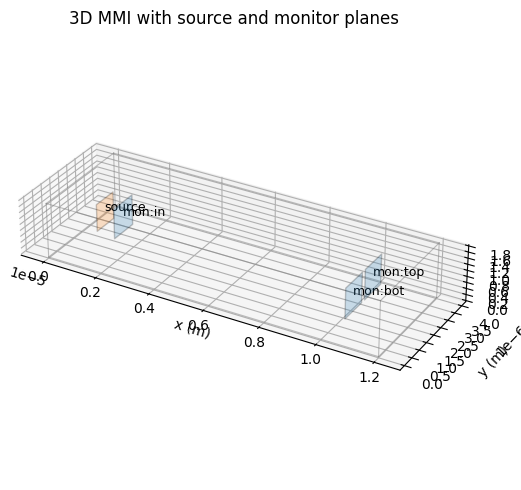

In [5]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def _normalize_plane_vertices(verts):
    if verts is None:
        return None
    arr = np.asarray(verts, dtype=float)

    # Accept common shapes: (N,3), (3,N), nested lists, etc.
    if arr.ndim != 2:
        return None
    if arr.shape[1] != 3 and arr.shape[0] == 3:
        arr = arr.T
    if arr.shape[1] != 3:
        return None

    # Remove duplicate closing vertex if provided
    if len(arr) >= 4 and np.allclose(arr[0], arr[-1]):
        arr = arr[:-1]

    # Need at least a triangle
    if len(arr) < 3:
        return None

    # Keep first 4 points for a plane patch if more were provided
    if len(arr) > 4:
        arr = arr[:4]

    return arr


def draw_plane(ax, verts, color, alpha=0.22, edge_color='k', label=None):
    verts_arr = _normalize_plane_vertices(verts)
    if verts_arr is None:
        return False

    poly = Poly3DCollection([verts_arr], alpha=alpha, facecolor=color, edgecolor=edge_color)
    ax.add_collection3d(poly)

    if label is not None:
        center = verts_arr.mean(axis=0)
        ax.text(center[0], center[1], center[2], label, fontsize=9, color=edge_color)

    return True


def source_plane_vertices(center, width, height):
    x0, y0, z0 = center
    y1, y2 = y0 - width / 2, y0 + width / 2
    z1, z2 = z0 - height / 2, z0 + height / 2
    return [(x0, y1, z1), (x0, y2, z1), (x0, y2, z2), (x0, y1, z2)]


# Keep BEAMZ native geometry view
design.show()

# Build temporary monitors if cell 4 was not run
if '_tmp_monitors' not in globals() or not isinstance(_tmp_monitors, dict):
    _tmp_monitors = make_monitors()

# Overlay source and monitor planes in a simple 3D scene
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Domain wireframe
domain = np.array([
    [0, 0, 0], [X, 0, 0], [X, Y, 0], [0, Y, 0],
    [0, 0, Z], [X, 0, Z], [X, Y, Z], [0, Y, Z],
], dtype=float)

for e in [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]:
    p0, p1 = domain[e[0]], domain[e[1]]
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], color='gray', lw=0.8, alpha=0.5)

# Draw source plane (input excitation reference)
src_center_ref = (x_src, y_mid, z_mid)
draw_plane(
    ax,
    source_plane_vertices(src_center_ref, source_width, source_height),
    color='tab:orange',
    label='source',
)

# Draw monitor planes
for name, mon in _tmp_monitors.items():
    verts = getattr(mon, 'vertices', None)

    # Fallback reconstruction for x-normal monitors if vertices missing/malformed
    if _normalize_plane_vertices(verts) is None:
        pos = getattr(mon, 'position', None)
        size = getattr(mon, 'size', None)
        if pos is not None and size is not None and len(pos) == 3 and len(size) == 2:
            cx, cy, cz = pos
            sy, sz = size
            verts = [
                (cx, cy - sy / 2, cz - sz / 2),
                (cx, cy + sy / 2, cz - sz / 2),
                (cx, cy + sy / 2, cz + sz / 2),
                (cx, cy - sy / 2, cz + sz / 2),
            ]

    ok = draw_plane(ax, verts, color='tab:blue', label=f'mon:{name}')
    if not ok:
        print(f"Warning: could not draw monitor '{name}' (invalid vertices).")

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_title('3D MMI with source and monitor planes')

# Matplotlib compatibility fallback
if hasattr(ax, 'set_box_aspect'):
    ax.set_box_aspect((float(X), float(Y), float(Z)))

plt.tight_layout()
plt.show()


## 6) Mode Calculation and Mode Profile Visualization

Effective index (neff): 2.370868+0.000000j


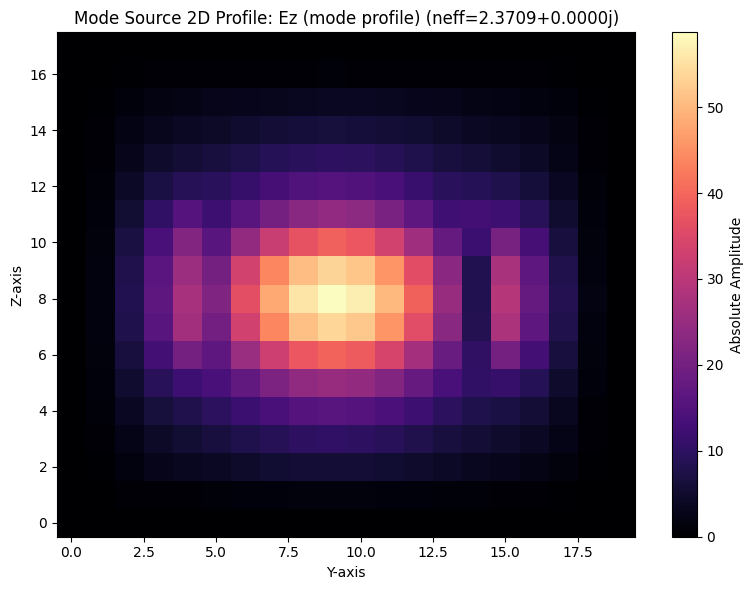

[ModeSource] 3D mode profiles saved to mode_profile.png


In [6]:
# Build a narrowband source for mode initialization
time_sf = single_freq_cfg["time"]
signal_sf = ramped_cosine(
    time_sf,
    amplitude=1.0,
    frequency=F0,
    phase=0.0,
    ramp_duration=single_freq_cfg["ramp_duration"],
    t_max=single_freq_cfg["t_max"],
)

source_ref = make_source(signal_sf, center_xyz=(x_src, y_mid, z_mid), direction="+x")
source_ref.initialize(grid.permittivity, DX)

assert np.isfinite(source_ref._neff), "Mode solve returned non-finite neff"
assert source_ref._Ez_profile is not None, "Mode profile not initialized"

print(f"Effective index (neff): {source_ref._neff:.6f}")
source_ref.show()

# Optional: 6-component profile panel if available
if hasattr(source_ref, "_plot_mode_profile_3d"):
    source_ref._plot_mode_profile_3d()

## 7) Signal Definitions (Narrowband and Broadband)

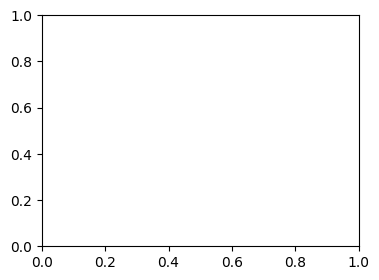

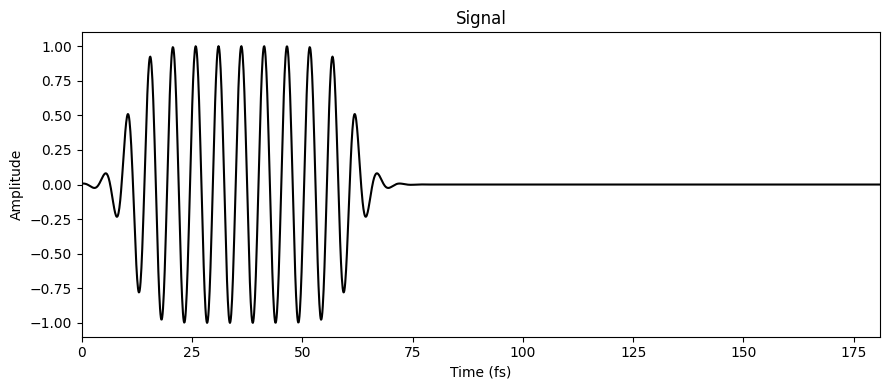

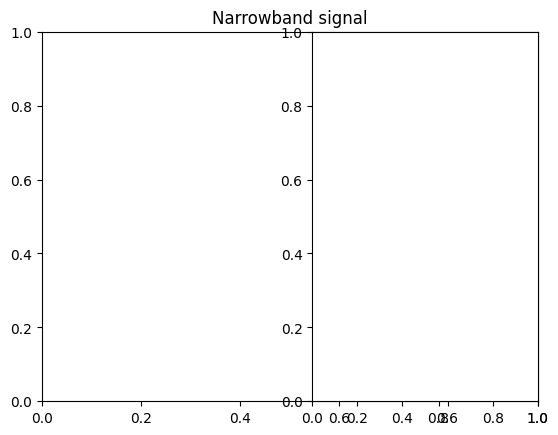

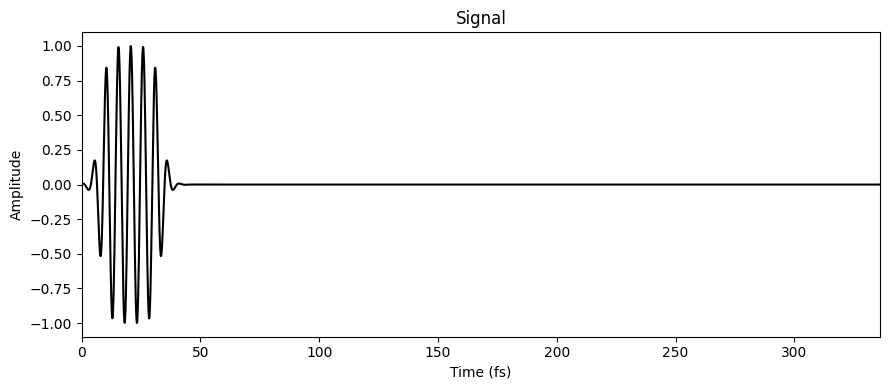

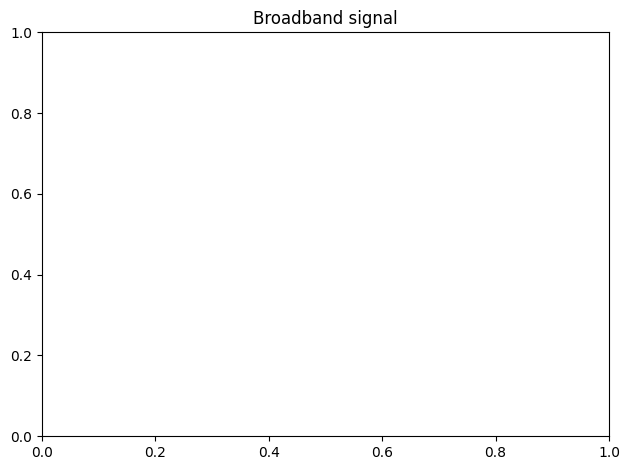

In [7]:
time_bb = broadband_cfg["time"]

signal_bb = ramped_cosine(
    time_bb,
    amplitude=1.0,
    frequency=F0,
    phase=0.0,
    ramp_duration=broadband_cfg["ramp_duration"],
    t_max=broadband_cfg["t_max"],
)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plot_signal(signal_sf, time_sf)
plt.title("Narrowband signal")

plt.subplot(1, 2, 2)
plot_signal(signal_bb, time_bb)
plt.title("Broadband signal")
plt.tight_layout()
plt.show()

## 8) Single-Frequency Simulation Helper (3 Port Excitations)

In [8]:
PORTS = {
    "in": {
        "center": (x_src, y_mid, z_mid),
        "direction": "+x",
        "ref_monitor": "in",
    },
    "top": {
        "center": (x_out_mon - 0.45 * um, y_top, z_mid),
        "direction": "-x",
        "ref_monitor": "top",
    },
    "bot": {
        "center": (x_out_mon - 0.45 * um, y_bot, z_mid),
        "direction": "-x",
        "ref_monitor": "bot",
    },
}


def _monitor_mean_trace(mon, field="Ez"):
    arr = np.asarray(mon.fields[field])
    if arr.size == 0:
        raise RuntimeError(f"Monitor {mon.name} has no recorded {field} data.")
    # Average over monitor area -> scalar time trace
    return arr.reshape(arr.shape[0], -1).mean(axis=1)


def run_single_freq(port_excitation, save_full_fields=False):
    cfg = PORTS[port_excitation]
    monitors = make_monitors()

    src = make_source(signal_sf, center_xyz=cfg["center"], direction=cfg["direction"])

    sim = Simulation(
        design=design,
        devices=[src, monitors["in"], monitors["top"], monitors["bot"]],
        boundaries=[PML(edges="all", thickness=0.8 * um)],
        time=time_sf,
        resolution=DX,
    )

    save_fields = ["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"] if save_full_fields else []

    result = sim.run(
        save_fields=save_fields,
        field_subsample=single_freq_cfg["field_subsample"],
        store_animation=False,
    )

    # Basic output checks
    for m in monitors.values():
        assert len(m.power_history) > 0, f"No power recorded for monitor {m.name}"
        assert len(m.fields["Ez"]) > 0, f"No field data recorded for monitor {m.name}"

    monitor_traces = {
        name: _monitor_mean_trace(mon, field="Ez") for name, mon in monitors.items()
    }
    port_powers = {name: np.asarray(mon.power_history) for name, mon in monitors.items()}

    return {
        "port": port_excitation,
        "ref_monitor": cfg["ref_monitor"],
        "time": np.asarray(time_sf),
        "source": src,
        "monitors": monitors,
        "monitor_traces": monitor_traces,
        "port_powers": port_powers,
        "result": result,
    }

## 9) Run Single-Frequency Characterization (3 Excitations)

In [9]:
single_freq_runs = {}
for p in ["in", "top", "bot"]:
    print(f"Running single-frequency excitation from port: {p}")
    single_freq_runs[p] = run_single_freq(p, save_full_fields=(p == "in"))

print("All single-frequency runs complete.")

Running single-frequency excitation from port: in
Running single-frequency excitation from port: top
Running single-frequency excitation from port: bot
All single-frequency runs complete.


## 10) Animated 2D Cross-Section (yz at fixed x)

In [10]:
run_in = single_freq_runs["in"]
fields = run_in["result"].get("fields", {})
Ez_4d = np.asarray(fields["Ez"])

assert Ez_4d.ndim == 4, f"Expected 4D Ez field array, got shape {Ez_4d.shape}"

# Ez shape: (Nt, z, y, x)
x_mid_idx = Ez_4d.shape[-1] // 2
Ez_yz = Ez_4d[:, :, :, x_mid_idx]  # (Nt, z, y)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(Ez_yz[0].T, origin="lower", cmap="twilight_zero", aspect="auto")
ax.set_title("Ez cross-section (yz) at x = x_mid")
ax.set_xlabel("z index")
ax.set_ylabel("y index")
plt.colorbar(im, ax=ax)


def _update(frame):
    im.set_data(Ez_yz[frame].T)
    ax.set_title(f"Ez yz cross-section, frame {frame}")
    return [im]

anim = FuncAnimation(fig, _update, frames=len(Ez_yz), interval=80, blit=True)
plt.close(fig)
anim

## 11) Time-Integrated Flux Map on yz Cross-Section

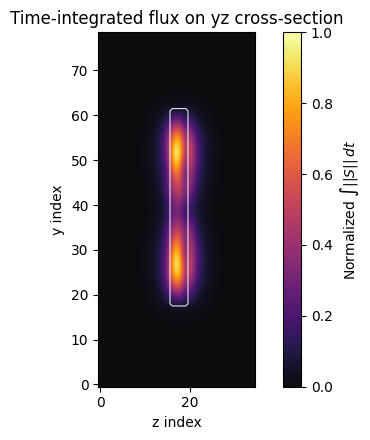

In [11]:
Ex_4d = np.asarray(fields["Ex"])
Ey_4d = np.asarray(fields["Ey"])
Ez_4d = np.asarray(fields["Ez"])
Hx_4d = np.asarray(fields["Hx"])
Hy_4d = np.asarray(fields["Hy"])
Hz_4d = np.asarray(fields["Hz"])

for name, arr in {
    "Ex": Ex_4d, "Ey": Ey_4d, "Ez": Ez_4d,
    "Hx": Hx_4d, "Hy": Hy_4d, "Hz": Hz_4d,
}.items():
    assert arr.ndim == 4, f"{name} expected 4D, got {arr.shape}"

# Align all components to common overlapping tensor to handle Yee staggering
shapes = [a.shape for a in [Ex_4d, Ey_4d, Ez_4d, Hx_4d, Hy_4d, Hz_4d]]
nt = min(s[0] for s in shapes)
nz = min(s[1] for s in shapes)
ny = min(s[2] for s in shapes)
nx = min(s[3] for s in shapes)

Ex_c = Ex_4d[:nt, :nz, :ny, :nx]
Ey_c = Ey_4d[:nt, :nz, :ny, :nx]
Ez_c = Ez_4d[:nt, :nz, :ny, :nx]
Hx_c = Hx_4d[:nt, :nz, :ny, :nx]
Hy_c = Hy_4d[:nt, :nz, :ny, :nx]
Hz_c = Hz_4d[:nt, :nz, :ny, :nx]

x_mid_idx = nx // 2
Ex_yz = Ex_c[:, :, :, x_mid_idx]
Ey_yz = Ey_c[:, :, :, x_mid_idx]
Ez_yz = Ez_c[:, :, :, x_mid_idx]
Hx_yz = Hx_c[:, :, :, x_mid_idx]
Hy_yz = Hy_c[:, :, :, x_mid_idx]
Hz_yz = Hz_c[:, :, :, x_mid_idx]

# Poynting vector in yz slice
Sx = Ey_yz * Hz_yz - Ez_yz * Hy_yz
Sy = Ez_yz * Hx_yz - Ex_yz * Hz_yz
Sz = Ex_yz * Hy_yz - Ey_yz * Hx_yz
S_mag = np.sqrt(np.abs(Sx)**2 + np.abs(Sy)**2 + np.abs(Sz)**2)

flux_int = np.sum(S_mag, axis=0) * DT
flux_norm = flux_int / max(np.max(flux_int), 1e-20)

perm = np.asarray(grid.permittivity)
perm_c = perm[:nz, :ny, :nx]
perm_slice = perm_c[:, :, x_mid_idx]

fig, ax = plt.subplots(figsize=(6, 4.5))
im = ax.imshow(
    flux_norm.T,
    origin="lower",
    cmap="inferno",
    interpolation="bicubic",
    alpha=0.95,
)

# Optional contour overlay: guard against edge cases where contouring fails
try:
    level = 0.5 * (EPS_CORE + EPS_CLAD)
    pmin, pmax = float(np.min(perm_slice)), float(np.max(perm_slice))
    if pmin < level < pmax:
        ax.contour(
            perm_slice.T,
            levels=[level],
            colors="white",
            linewidths=0.7,
        )
except Exception as e:
    print(f"Warning: contour overlay skipped ({e}).")

fig.colorbar(im, ax=ax, label=r"Normalized $\int ||S||\,dt$")
ax.set_title("Time-integrated flux on yz cross-section")
ax.set_xlabel("z index")
ax.set_ylabel("y index")
fig.tight_layout()
plt.show()


## 12) Input and Output Monitor Signals

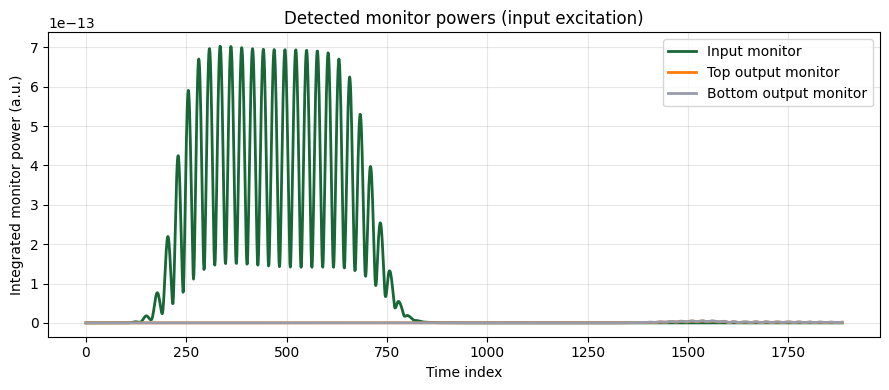

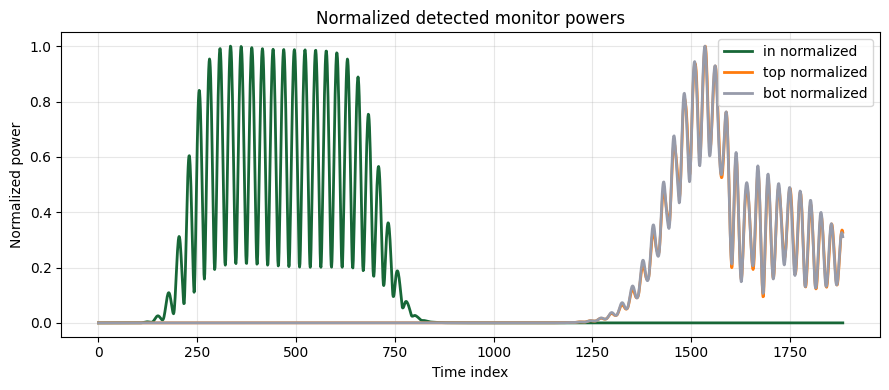

In [12]:
p_in = single_freq_runs["in"]["port_powers"]
t_idx = np.arange(len(p_in["in"]))

plt.figure(figsize=(9, 4))
plt.plot(t_idx, p_in["in"], label="Input monitor", linewidth=2)
plt.plot(t_idx, p_in["top"], label="Top output monitor", linewidth=2)
plt.plot(t_idx, p_in["bot"], label="Bottom output monitor", linewidth=2)
plt.xlabel("Time index")
plt.ylabel("Integrated monitor power (a.u.)")
plt.title("Detected monitor powers (input excitation)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
for name in ["in", "top", "bot"]:
    arr = np.asarray(p_in[name])
    arr_n = arr / np.max(np.abs(arr)) if np.max(np.abs(arr)) > 0 else arr
    plt.plot(arr_n, label=f"{name} normalized", linewidth=2)
plt.xlabel("Time index")
plt.ylabel("Normalized power")
plt.title("Normalized detected monitor powers")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 13) Build and Plot 3x3 S-Matrix at Center Wavelength

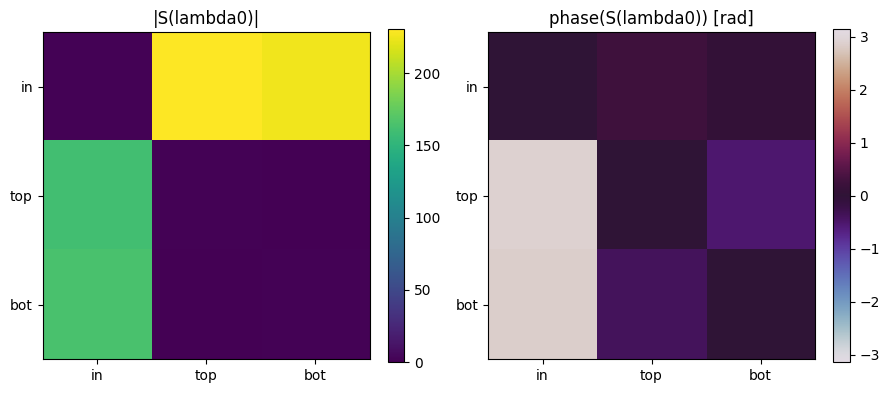

Reciprocity diagnostic max|S - S^T| = 3.828e+02
|S21|=160.605, |S31|=164.570, split ratio S21:S31 = 0.976


In [13]:
def harmonic_demod(trace, time, omega0, frac_start=0.55):
    n = len(trace)
    i0 = int(frac_start * n)
    tw = time[i0:]
    sw = trace[i0:]
    # Complex demodulation at carrier frequency
    return np.sum(sw * np.exp(-1j * omega0 * tw)) / len(sw)


omega0 = 2 * np.pi * F0
ports_order = ["in", "top", "bot"]
S = np.zeros((3, 3), dtype=complex)

for j, p_exc in enumerate(ports_order):
    run = single_freq_runs[p_exc]
    t = run["time"]
    traces = run["monitor_traces"]
    ref_port = run["ref_monitor"]

    a_ref = harmonic_demod(traces[ref_port], t, omega0)
    if np.abs(a_ref) < 1e-12:
        raise RuntimeError(f"Reference amplitude too small for excitation {p_exc}.")

    for i, p_det in enumerate(ports_order):
        a_det = harmonic_demod(traces[p_det], t, omega0)
        S[i, j] = a_det / a_ref

assert S.shape == (3, 3)
assert np.isfinite(S).all(), "Non-finite entries in S-matrix"

S_mag = np.abs(S)
S_phase = np.angle(S)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
im0 = axes[0].imshow(S_mag, cmap="viridis", vmin=0)
axes[0].set_title("|S(lambda0)|")
axes[0].set_xticks([0, 1, 2], ports_order)
axes[0].set_yticks([0, 1, 2], ports_order)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(S_phase, cmap="twilight", vmin=-np.pi, vmax=np.pi)
axes[1].set_title("phase(S(lambda0)) [rad]")
axes[1].set_xticks([0, 1, 2], ports_order)
axes[1].set_yticks([0, 1, 2], ports_order)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

recip_err = np.max(np.abs(S - S.T))
print(f"Reciprocity diagnostic max|S - S^T| = {recip_err:.3e}")
print(f"|S21|={S_mag[1,0]:.3f}, |S31|={S_mag[2,0]:.3f}, split ratio S21:S31 = {S_mag[1,0]/max(S_mag[2,0],1e-12):.3f}")

## 14) Broadband FFT Analysis ($S_{11}, S_{21}, S_{31}$)

/var/folders/cv/559ytk0122scr1rx1xh08d6r0000gn/T/ipykernel_25852/738621082.py:33: RuntimeWarning:

divide by zero encountered in divide



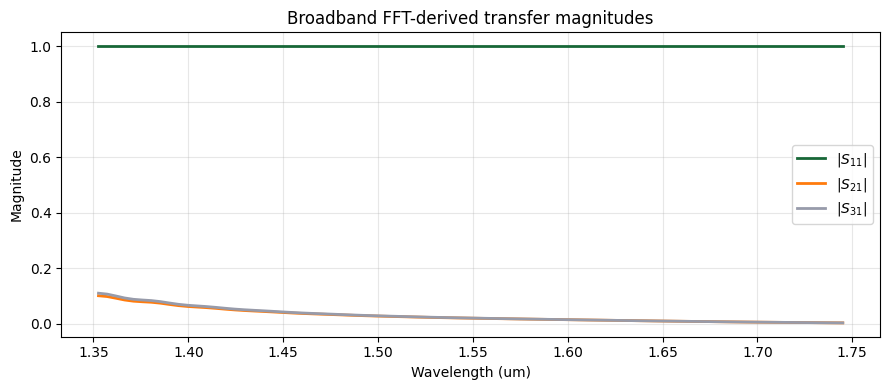

In [14]:
def run_broadband_input():
    monitors = make_monitors()
    src = make_source(signal_bb, center_xyz=(x_src, y_mid, z_mid), direction="+x")

    sim = Simulation(
        design=design,
        devices=[src, monitors["in"], monitors["top"], monitors["bot"]],
        boundaries=[PML(edges="all", thickness=0.8 * um)],
        time=time_bb,
        resolution=DX,
    )

    _ = sim.run(
        save_fields=[],
        field_subsample=broadband_cfg["field_subsample"],
        store_animation=False,
    )

    return {
        "time": np.asarray(time_bb),
        "monitors": monitors,
        "traces": {name: _monitor_mean_trace(mon, field="Ez") for name, mon in monitors.items()},
    }


bb = run_broadband_input()
tb = bb["time"]
tr = bb["traces"]

# FFT spectra
n_fft = 4 * len(tb)
freq = np.fft.rfftfreq(n_fft, DT)
wl = np.where(freq > 0, LIGHT_SPEED / freq, np.inf)

E_in = np.fft.rfft(tr["in"], n=n_fft)
E_top = np.fft.rfft(tr["top"], n=n_fft)
E_bot = np.fft.rfft(tr["bot"], n=n_fft)

valid = np.abs(E_in) > (1e-4 * np.max(np.abs(E_in)))

S11 = np.where(valid, E_in / E_in, np.nan + 1j * np.nan)
S21 = np.where(valid, E_top / E_in, np.nan + 1j * np.nan)
S31 = np.where(valid, E_bot / E_in, np.nan + 1j * np.nan)

wl_mask = (wl >= broadband_cfg["wl_min"]) & (wl <= broadband_cfg["wl_max"]) & valid
wl_plot = wl[wl_mask]

sort_idx = np.argsort(wl_plot)
wl_plot = wl_plot[sort_idx]
S11_plot = S11[wl_mask][sort_idx]
S21_plot = S21[wl_mask][sort_idx]
S31_plot = S31[wl_mask][sort_idx]

assert wl_plot.size > 0, "No valid broadband points in wavelength window"

plt.figure(figsize=(9, 4))
plt.plot(wl_plot / um, np.abs(S11_plot), label=r"$|S_{11}|$", linewidth=2)
plt.plot(wl_plot / um, np.abs(S21_plot), label=r"$|S_{21}|$", linewidth=2)
plt.plot(wl_plot / um, np.abs(S31_plot), label=r"$|S_{31}|$", linewidth=2)
plt.xlabel("Wavelength (um)")
plt.ylabel("Magnitude")
plt.title("Broadband FFT-derived transfer magnitudes")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 15) Circuit-Model Export Snippet

In [15]:
from pathlib import Path

export_dir = Path("notebooks/data")
export_dir.mkdir(parents=True, exist_ok=True)

export_npz = export_dir / "mmi_3d_sparams.npz"
export_csv = export_dir / "mmi_3d_sparams_mag.csv"

np.savez(
    export_npz,
    wavelength=wl_plot,
    S11=S11_plot,
    S21=S21_plot,
    S31=S31_plot,
    S_center=S,
    ports=np.array(["in", "top", "bot"]),
    meta=np.array([
        f"WL0={WL0}",
        f"DX={DX}",
        f"DT={DT}",
        f"n_core={N_CORE}",
        f"n_clad={N_CLAD}",
    ], dtype=object),
)

csv_data = np.column_stack([
    wl_plot / um,
    np.abs(S11_plot),
    np.abs(S21_plot),
    np.abs(S31_plot),
])
np.savetxt(
    export_csv,
    csv_data,
    delimiter=",",
    header="wavelength_um,abs_S11,abs_S21,abs_S31",
    comments="",
)

print(f"Saved NPZ: {export_npz}")
print(f"Saved CSV: {export_csv}")

Saved NPZ: notebooks/data/mmi_3d_sparams.npz
Saved CSV: notebooks/data/mmi_3d_sparams_mag.csv


## 16) Validation Checks

This notebook includes checks for:
- dependency gating (`tidy3d` for mode solving),
- monitor geometry bounds,
- finite mode effective index and non-empty mode profiles,
- non-empty monitor power and field records,
- finite 3x3 S-matrix entries,
- non-empty masked broadband FFT region.

For physical interpretation, inspect:
- insertion/coupling near $\lambda_0$,
- top/bottom split balance,
- reciprocity diagnostic `max|S-S^T|`.

## 17) Conclusion and Next Steps

You now have a complete 3D MMI workflow from geometry and excitation to circuit-model export.

To extend this into a full **broadband 3x3 S-matrix**, repeat broadband excitation for the top and bottom ports and assemble all matrix columns versus wavelength.